In [1]:
import os
import cv2
import shutil
import PIL
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import model_selection
from pathlib import Path
from PIL import Image
from tqdm import tqdm

In [2]:
BASE_DIR = '../'
SAVED_MODEL_DIR = BASE_DIR + 'model'
DATASET_DIR = BASE_DIR + 'dataset/'
DATA_DIR = Path(DATASET_DIR)
IMG_HEIGHT = 256
IMG_WIDTH = 256
EPOCHS = 50
BATCH_SIZE = 128

In [36]:
ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    seed = 123)

ds_size = sum(1 for _ in ds.unbatch().take(-1))
print(f'[DEBUG] - ds_size: {ds_size}')
class_names = ds.class_names
ds = ds.shuffle(10000, seed=12)
print(f'[INFO] - Class names: {class_names}')

Found 20167 files belonging to 5 classes.
[INFO] - Class names: ['correctly-masked', 'correctly-masked-crop', 'correctly-masked-real', 'incorrectly-masked', 'not-masked']


In [ ]:
x = []
y = []
for image, label in tqdm(ds.unbatch().take(-1)):
    img = image.numpy().astype("uint8")
    x.append(img)
    label = label.numpy()
    y.append(label)

x = np.array(x)
y = np.array(y)

In [ ]:
x_train, x_val_test, y_train, y_val_test = model_selection.train_test_split(x, y, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = model_selection.train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=42)

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(), 
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

model.summary()

In [ ]:
start_time = time.time()
epochs = EPOCHS
history = model.fit(
  x_train, y_train,
  validation_data = (x_val, y_val),
  epochs = epochs
)
model.save(SAVED_MODEL_DIR)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
predictions = np.argmax(model.predict(x_test), axis=-1)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_test, predictions, 
                            target_names = ['correctly-masked (Class 0)','not-masked (Class 1)', 'uncorrectly-masked (Class 2)']))

9it [00:00, 89.94it/s]

Found 532 files belonging to 1 classes.


532it [00:00, 1276.24it/s]


Text(0.5, 1.0, 'not-masked')

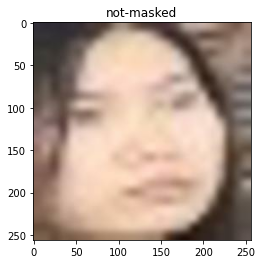

In [101]:
model = keras.models.load_model(SAVED_MODEL_DIR)
predict_dir = '/Users/davide/Documents/Università/VisionePercezione/mask-detector/pred_ds'
predict_ds = tf.keras.preprocessing.image_dataset_from_directory(
    predict_dir,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    seed = 123)
x_pred = []
for image, label in tqdm(predict_ds.unbatch().take(-1)):
    img = image.numpy().astype("uint8")
    x_pred.append(img)

x_pred = np.array(x_pred)

CLASS_NAMES = ['correctly-masked', 'not-masked', 'incorrectly-masked']
predictions = np.argmax(model.predict(x_pred), axis=-1)
predictions = predictions.reshape(1,-1)[0]

i = 517
plt.imshow(x_pred[i])
plt.title(CLASS_NAMES[predictions[i]])